## Part 3: Transfer training with Segformer model
- This part of the project aimed at utilising SegFormer Framework to see if it can enhance the predictions
- The SegFormer framework unifies Transformers encoders with lightweight multilayer perception (MLP) decoders

reference is made to https://huggingface.co/docs/transformers/en/model_doc/segformer

The SegFormer model was proposed in [SegFormer: Simple and Efficient Design for Semantic Segmentation with Transformers](https://arxiv.org/abs/2105.15203) by Enze Xie, Wenhai Wang, Zhiding Yu, Anima Anandkumar, Jose M. Alvarez, Ping Luo. The model consists of a hierarchical Transformer encoder and a lightweight all-MLP decode head to achieve great results on image segmentation benchmarks such as ADE20K and Cityscapes.

The below shown the architecture of the model:

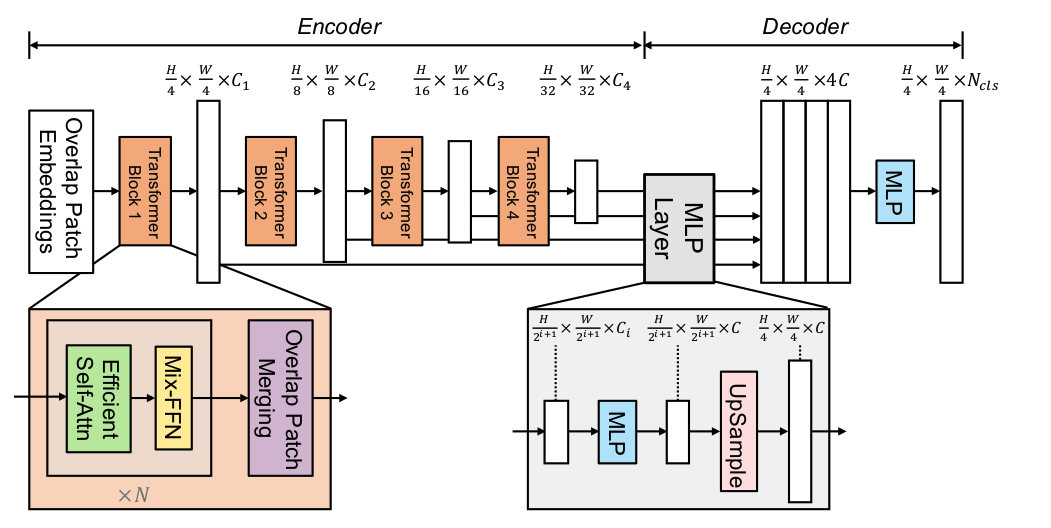

### 0.0 - importing modules

In [3]:
import os 
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import cv2 as cv
from PIL import Image as PILImage

import torch
from torch import nn
from torch import from_numpy
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import torchvision
import torchvision.transforms.v2 as transforms
from torchvision.transforms import transforms as T

import albumentations as A

from torch.autograd import detect_anomaly

from transformers import SegformerForSemanticSegmentation, TrainingArguments, \
                        Trainer, SegformerImageProcessor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2025-06-28 09:30:23.221017: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751103023.419367      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751103023.479134      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
torch.backends.cudnn.benchmark=True  # speeding up training for fixed input size
torch.backends.cudnn.deterministic = False # trading off some randomness for speed

## 1.1 - Data Preparation - Creating Dataset

- This part is largely similar to Part 1 and 2 of this project, except that labelling is required

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("franciscoescobar/satellite-images-of-water-bodies")

print("Path to dataset files:", path)

img_folder = path+"/Water Bodies Dataset/Images"
mask_folder = path+"/Water Bodies Dataset/Masks"

images_name = sorted(os.listdir(img_folder))
masks_name = sorted(os.listdir(mask_folder))

image_files_list  = [os.path.join(img_folder,img_name) for img_name in images_name]
mask_files_list  = [os.path.join(mask_folder,mask_name) for mask_name in masks_name]

Path to dataset files: /kaggle/input/satellite-images-of-water-bodies


In [7]:
## setting up labels for the model inference
id2label = {0: 'water', 1: 'ground'}
label2id = {label: id for id, label in id2label.items()}
num_labels = 2

In [83]:
#Custom class for loading Dataset
class SemanticSegmentationData(Dataset):
    def __init__(self, image_files_list, mask_files_list, device):
        """
        transforms: Torch transforms for image processing
        images_path, masks_path: image and mask path 
        
        images, masks: list of images and masks (to ease train and test split)
        device: cuda
        """
        self.image_files_list = image_files_list
        self.mask_files_list = mask_files_list
        self.device = device
    

    
    def __getitem__(self,index):
        """
        to Transform Image and mask, organize it to send to the model
        """
        # Read Images and masks
        img = PILImage.open(self.image_files_list[index])
        img = T.Resize((560, 560))(img)
        img = T.CenterCrop((512,512))(img)
        img_tensor = T.ToTensor()(img)
        
        mask = PILImage.open(self.mask_files_list[index])
        mask = T.Resize((560, 560))(mask)
        mask = T.CenterCrop((512,512))(mask)
        mask = T.Resize((128,128))(mask) # Segformer Outputs 128x128 mask, so resizing masks to compare metrics
        mask = np.mean(np.asarray(mask),axis=2)/255.0
        mask_tensor = from_numpy(mask.round().astype(np.int32)).long()
               
        # Organizing Image in 'pixel_values' and mask in 'labels'
        image_tensor = {}
        image_tensor['labels'] = mask_tensor
        image_tensor['pixel_values'] = img_tensor.to(self.device)
        
        return image_tensor
    
    
    def __len__(self):
        # return length of images
        return len(self.image_files_list)

In [84]:
# 80 % of the dataset is used for training
X_train , X_val , y_train, y_val = train_test_split(image_files_list, mask_files_list,test_size = 0.2 , random_state=42)

In [85]:
# Dataset for training
segmentationDataTrain = SemanticSegmentationData(X_train, y_train,device)
segmentationDataVal = SemanticSegmentationData(X_val, y_val,device)

## 2.1 -  Downloading Pre-trained Model 
- The smallest model with 3.7M parameter is being used in this notebook

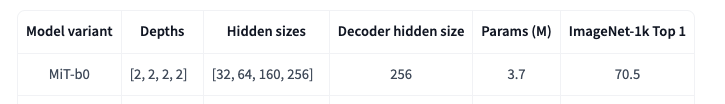

In [8]:
MODEL_CHECKPOINT = 'nvidia/mit-b0'  # b1 to b5

model = SegformerForSemanticSegmentation.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    # ignore_mismatched_sizes=True,
)

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/14.3M [00:00<?, ?B/s]

In [9]:
# printing the model framework
model.eval()

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

## 3.1 - Setting up loss functions and training argument of the model

- Instead of using only BCE , which is the default loss function of the pretrained model
- I have alter the compute loss function by using the combination of both DICE loss and BCE loss
- This can help with the imbalance dataset as the waterbodies in the image are quite often only occupied small portion of the image

In [82]:
class SegFormerTrainerWithCombinedLoss(Trainer):
    def __init__(self, *args, bce_weight=0.5, dice_weight=0.5, **kwargs):
        super().__init__(*args, **kwargs)
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
    
    def dice_loss(self, pred_logits, target, smooth=1e-6):

        pred_probs = F.softmax(pred_logits, dim=1)[:, 0, :, :]

        # Flatten tensors 
        pred_flat = pred_probs.reshape(-1)
        target_flat = target.reshape(-1).float()
        
        intersection = (pred_flat * target_flat).sum()
        union = pred_flat.sum() + target_flat.sum()
        dice_coeff = (2.0 * intersection + smooth) / (union + smooth)
        return 1 - dice_coeff
    
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        
        #Overriding compute_loss to use combined BCE + Dice loss
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        logits_flat = logits[:, 0, :, :]  # Take class 0
        bce_loss = F.binary_cross_entropy_with_logits(logits_flat, labels.float())
       
        # Calculate Dice loss
        dice_loss_val = self.dice_loss(logits, labels)
        
        # Combine losses
        combined_loss = self.bce_weight * bce_loss + self.dice_weight * dice_loss_val
        
        return (combined_loss, outputs) if return_outputs else combined_loss


In [87]:
model = model.to(device)

In [90]:

# Initializing Training Arguments
train_args = TrainingArguments(output_dir = "/kaggle/working/",
                               num_train_epochs = 5 , # Number of epochs
                               # max_steps = 500,
                               per_device_train_batch_size = 2, # Batch size
                               save_total_limit = 4,
                               dataloader_pin_memory = False, # DOnot pin to memory, so that torch long() can be used
                               eval_strategy="steps", 
                               logging_steps = 50, 
                               save_strategy="steps", # save at steps ^
                               load_best_model_at_end=True, # Load the best model at end
                               hub_model_id = "SCYS/WaterBodies", # ID to push to hub in case needed
                               report_to="none"  # 
                              )

trainer = SegFormerTrainerWithCombinedLoss(
                model=model, 
                args=train_args,
                train_dataset=segmentationDataTrain,
                # compute_metrics=compute_metrics,
                eval_dataset=segmentationDataVal,
                bce_weight=0.6,  # using same weight as other model
                dice_weight=0.4
            )

## 4.1 - Training the model

- The result has shown significant improvement compared with pure Unet or Unet++ in part 1 and 2 of this project

In [91]:
trainer.train()

Step,Training Loss,Validation Loss
50,0.318200,0.238174
100,0.238300,0.201789
150,0.315100,0.234154
200,0.258100,0.197086
250,0.243700,0.192522
300,0.228000,0.180599
350,0.251300,0.181701
400,0.221000,0.169623
450,0.239000,0.173355
500,0.215900,0.183607


TrainOutput(global_step=2840, training_loss=0.19470990711534528, metrics={'train_runtime': 8344.2639, 'train_samples_per_second': 1.361, 'train_steps_per_second': 0.34, 'total_flos': 1.9911757472464896e+17, 'train_loss': 0.19470990711534528, 'epoch': 5.0})

### Sense checking by visualising result by running the model on 10 random images

- It can be noted that the prediction result is very well from naked eye
- In some cases it might even look more trustworthy then the actual label , which could be cases that it is some error that can only be distinguished by experts (the annotator of the dataset)

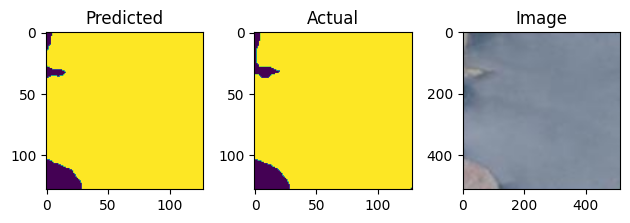

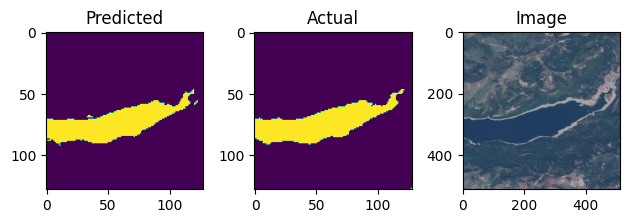

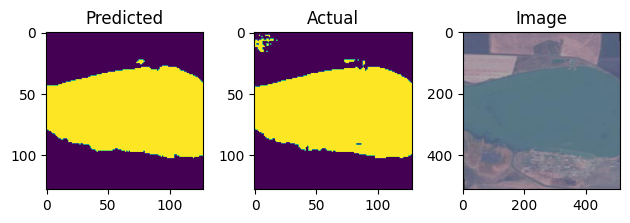

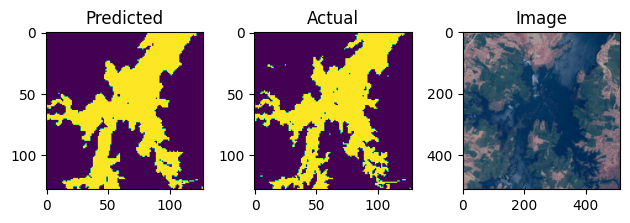

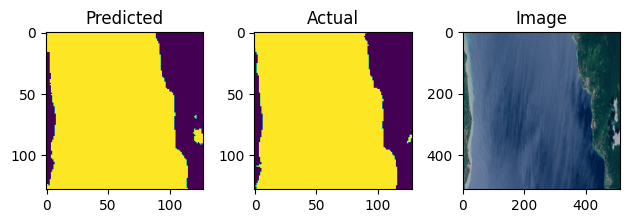

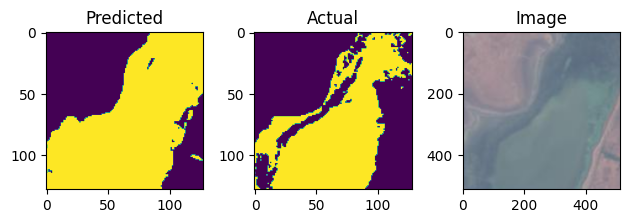

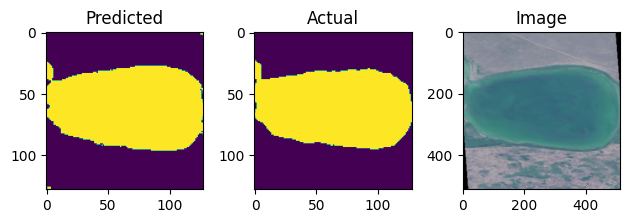

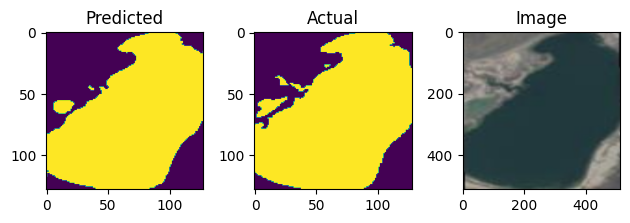

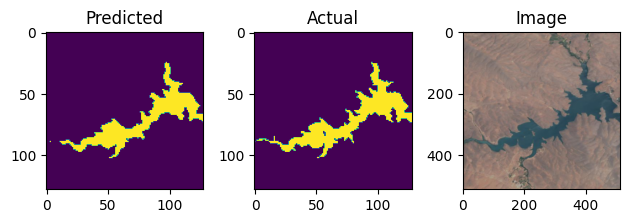

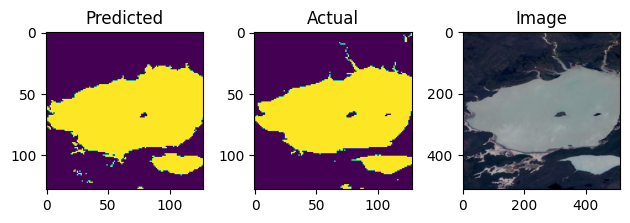

In [135]:
from random import sample,seed
seed(42)
# Visualize the Model 
def visualize_model(images_list):
    for i in images_list:
        temp = i['pixel_values'].unsqueeze(0)
        with model.eval() and torch.no_grad(): # Set evaluation mode without gradient calculation
            out = model(temp) # run the model over data
            output = out.logits.squeeze() # get logits
            output1 = ~output.argmax(0).detach().cpu()
            fig,axes = plt.subplots(1,3) # Three Columns for pred, actual and Image
            axes[0].set_title("Predicted")
            axes[0].imshow(output1)
            axes[1].set_title("Actual")
            axes[1].imshow(i['labels'].detach().cpu())
            axes[2].set_title("Image")
            axes[2].imshow(temp.detach().cpu().squeeze().permute(1,2,0))
            plt.tight_layout()
            plt.show()
# Visualizing random 10 images from the complete dataset training
visualize_model([segmentationDataTrain[i] for i in sample(range(0, len(segmentationDataTrain)-30), 10)])


## 5.1 - Plotting the result

The Training loss are noted often lower than the validation losses , this can due to few reasons:
- The regulariztion techniques such as Dropout or batch normalization are only active during the training process and is turned off or uses running statistics during the evaluation process to preven overfitting , hence the validation loss can be smaller than that of training loss
- The training losses are also compute during the training instead of after the training , hence there would be slight discount to the losses too

In [115]:
def parse_losses(trainer):
    """
    Plot training and validation losses from trainer log history
    """
    # Get log history
    log_history = trainer.state.log_history
    
    train_losses = {}
    eval_losses = {}
    
    for entry in log_history:
        if 'loss' in entry:
            train_losses[entry['step']] = entry['loss']
            
        if 'train_loss' in entry:
            train_losses[entry['step']] = entry['train_loss']
        
        if 'eval_loss' in entry:
            eval_losses[entry['step']]=entry['eval_loss']
    
    return train_losses, eval_losses

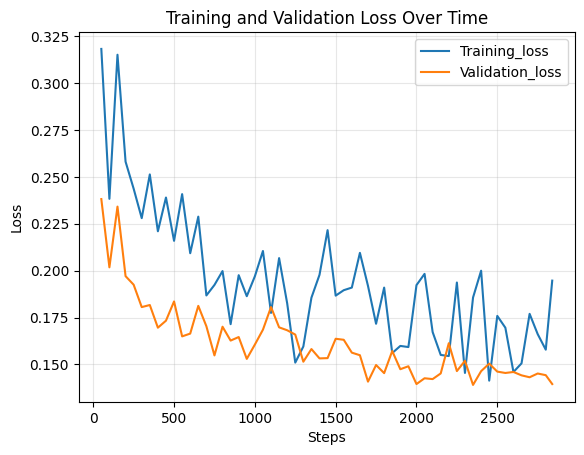

In [119]:
result = pd.DataFrame(parse_losses(trainer)).T
result.columns = ['Training_loss','Validation_loss']
result.plot()
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid(True, alpha=0.3)

## 6.1 - Saving the Model and results

In [121]:
model.save_pretrained('/kaggle/working/segformer_waterbodies')

In [123]:
result.to_csv('/kaggle/working/segformer_losses_log.csv')

In [128]:
import subprocess
import sys

# Get installed packages
result = subprocess.run([sys.executable, '-m', 'pip', 'freeze'], 
                       capture_output=True, text=True)

with open('/kaggle/working/segformer_requirements.txt', 'w') as f:
    f.write(result.stdout)

print("Requirements saved to requirements.txt")

Requirements saved to requirements.txt
